# PROJECT

## Introduction  
This notebook trains two models for a movie recommender system using the MovieLens 100K dataset:
- A user-based model using Neural Collaborative Filtering (NCF)
- An item similarity model using cosine similarity on embeddings

We will follow the full ML pipeline: data loading → preprocessing → modeling → saving.


## About Data
Columns:
- userId (int): Unique identifier for users
- movieId (int): Unique identifier for movies
- rating (float): Rating given by a user to a movie (range 0.5–5.0)
- timestamp (int): When the rating was given (not used now)
- title (object): Movie title
- genres (object): Movie genres


## `01` Import Libraries

In [ ]:
import pandas as pd  

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

from dotenv import load_dotenv
import requests
import os

import pandas as pd
import ast


In [104]:
load_dotenv("../.env")

True

In [105]:
TMDB_API_KEY= os.getenv("TMDB_API_KEY")

## `02` Read Data

In [106]:
ratings = pd.read_csv("../data/ratings.csv")
movies = pd.read_csv("../data/movies.csv")

df = ratings.merge(movies, on="movieId")

## `03` EDA

In [107]:
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [108]:
print(df.shape)     

(100836, 6)


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
 4   title      100836 non-null  object 
 5   genres     100836 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 4.6+ MB


In [110]:
df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

Unique users: 610
Unique movies: 9724


<Axes: >

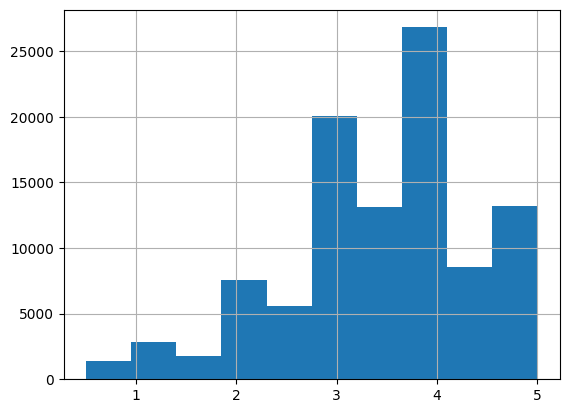

In [111]:
print("Unique users:", df['userId'].nunique())
print("Unique movies:", df['movieId'].nunique())
df['rating'].hist()

---
## New Movies
---

In [112]:
new_movies = pd.read_csv("../data/new_movies.csv")

In [113]:
new_movies.shape

(9742, 28)

In [114]:
new_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                9742 non-null   int64  
 1   tmdbId                 9734 non-null   float64
 2   adult                  9623 non-null   object 
 3   backdrop_path          9513 non-null   object 
 4   belongs_to_collection  2068 non-null   object 
 5   budget                 9623 non-null   float64
 6   genres                 9742 non-null   object 
 7   homepage               2639 non-null   object 
 8   id                     9623 non-null   float64
 9   imdb_id                9622 non-null   object 
 10  origin_country         9623 non-null   object 
 11  original_language      9623 non-null   object 
 12  original_title         9623 non-null   object 
 13  overview               9621 non-null   object 
 14  popularity             9623 non-null   float64
 15  post

In [115]:
new_movies.drop(columns=['backdrop_path', 'homepage', 'imdb_id', 'original_title', 'overview', 'poster_path', 'spoken_languages', 'tagline', 'video', 'belongs_to_collection', 'budget', 'production_companies'], inplace= True)

In [116]:
new_movies

,movieId,tmdbId,adult,genres,id,origin_country,original_language,popularity,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count
0,1,862.0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",862.0,['US'],en,21.4021,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-11-22,394436586.0,81.0,Released,Toy Story,7.969,18889.0
1,2,8844.0,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844.0,['US'],en,3.0047,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262821940.0,104.0,Released,Jumanji,7.237,10783.0
2,3,15602.0,False,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602.0,['US'],en,1.4596,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,71500000.0,101.0,Released,Grumpier Old Men,6.500,398.0
3,4,31357.0,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357.0,['US'],en,1.6120,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,Released,Waiting to Exhale,6.300,173.0
4,5,11862.0,False,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",11862.0,['US'],en,2.0869,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-08,76594107.0,106.0,Released,Father of the Bride Part II,6.237,754.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,432131.0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 28, '...",432131.0,['JP'],ja,1.6639,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2017-01-21,511132.0,100.0,Released,Black Butler: Book of the Atlantic,7.600,93.0
9738,193583,445030.0,False,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",445030.0,['JP'],ja,2.7855,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2017-07-15,6356284.0,106.0,Released,No Game No Life: Zero,7.800,408.0
9739,193585,479308.0,False,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 18,...",479308.0,['US'],en,0.3624,"[{'iso_3166_1': 'US', 'name': 'United States o...",2017-10-28,0.0,96.0,Released,Flint,6.806,18.0
9740,193587,483455.0,False,"[{'id': 16, 'name': 'Animation'}, {'id': 28, '...",483455.0,['JP'],ja,6.0790,"[{'iso_3166_1': 'JP', 'name': 'Japan'}]",2018-03-03,2373203.0,90.0,Released,Bungo Stray Dogs: Dead Apple,8.123,163.0


In [117]:
new_movies.isnull().sum()

movieId                   0
tmdbId                    8
adult                   119
genres                    0
id                      119
origin_country          119
original_language       119
popularity              119
production_countries    119
release_date            119
revenue                 119
runtime                 119
status                  119
title                     0
vote_average            119
vote_count              119
dtype: int64

In [118]:
new_movies[new_movies.isnull().sum(axis=1) >= 1]

,movieId,tmdbId,adult,genres,id,origin_country,original_language,popularity,production_countries,release_date,revenue,runtime,status,title,vote_average,vote_count
624,791,NaN,NaN,"[{'id': 0, 'name': 'Documentary'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Last Klezmer: Leopold Kozlowski, His Life and ...",NaN,NaN
843,1107,NaN,NaN,"[{'id': 0, 'name': 'Comedy'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loser (1991),NaN,NaN
2141,2851,NaN,NaN,"[{'id': 0, 'name': 'Adventure'}, {'id': 0, 'na...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturn 3 (1980),NaN,NaN
3027,4051,NaN,NaN,"[{'id': 0, 'name': 'Horror'}, {'id': 0, 'name'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Horrors of Spider Island (Ein Toter Hing im Ne...,NaN,NaN
3127,4207,12773.0,NaN,"[{'id': 0, 'name': 'Action'}, {'id': 0, 'name'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Navy Seals (1990),NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9603,176329,466986.0,NaN,"[{'id': 0, 'name': 'Comedy'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Ari Shaffir: Double Negative (2017),NaN,NaN
9634,179135,463612.0,NaN,"[{'id': 0, 'name': 'Documentary'}]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Blue Planet II (2017),NaN,NaN
9651,180263,106035.0,NaN,"[{'id': 0, 'name': 'Drama'}, {'id': 0, 'name':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Shining (1997),NaN,NaN
9690,184257,502892.0,NaN,"[{'id': 0, 'name': 'Crime'}, {'id': 0, 'name':...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Making a Murderer (2015),NaN,NaN


Same 119 has all the missing values so i will drop them 

In [119]:
new_movies.dropna(inplace=True)

In [120]:
new_movies.shape

(9623, 16)

In [121]:
new_movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9623 entries, 0 to 9741
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieId               9623 non-null   int64  
 1   tmdbId                9623 non-null   float64
 2   adult                 9623 non-null   object 
 3   genres                9623 non-null   object 
 4   id                    9623 non-null   float64
 5   origin_country        9623 non-null   object 
 6   original_language     9623 non-null   object 
 7   popularity            9623 non-null   float64
 8   production_countries  9623 non-null   object 
 9   release_date          9623 non-null   object 
 10  revenue               9623 non-null   float64
 11  runtime               9623 non-null   float64
 12  status                9623 non-null   object 
 13  title                 9623 non-null   object 
 14  vote_average          9623 non-null   float64
 15  vote_count            9623

### Encode the generes column 

In [135]:
geners_df = new_movies.genres.copy()
geners_df

0       [{'id': 16, 'name': 'Animation'}, {'id': 12, '...
1       [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2       [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3       [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4       [{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...
                              ...                        
9737    [{'id': 16, 'name': 'Animation'}, {'id': 28, '...
9738    [{'id': 12, 'name': 'Adventure'}, {'id': 16, '...
9739    [{'id': 10770, 'name': 'TV Movie'}, {'id': 18,...
9740    [{'id': 16, 'name': 'Animation'}, {'id': 28, '...
9741                       [{'id': 35, 'name': 'Comedy'}]
Name: genres, Length: 9623, dtype: object

In [137]:
# Step 1: Convert the string to actual lists (if needed)
geners_df = new_movies['genres'].apply(ast.literal_eval)

# Step 2: Extract only the names
genre_names = geners_df.apply(lambda genre_list: [g['name'] for g in genre_list])

# Step 3: Get all unique genres
all_genres = sorted(set(g for sublist in genre_names for g in sublist))

# Step 4: Create the one-hot dataframe
genre_ohe = pd.DataFrame(0, index=new_movies.index, columns=all_genres)

for i, genres in genre_names.items():
    genre_ohe.loc[i, genres] = 1


In [134]:
genre_ohe

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
9738,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
9739,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
9740,1,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0


### Merge back to the new_moves in all_movies df 

---

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)